# Import Dataset

In [16]:
import re
import nltk
import emoji
import unicodedata
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from textblob import TextBlob
from wordcloud import WordCloud
from nltk.corpus import stopwords
from sklearn.pipeline import Pipeline
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import TfidfVectorizer

import warnings
warnings.filterwarnings('ignore')

In [17]:
nltk.download('wordnet', download_dir='/Users/mac/nltk_data')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Error loading wordnet: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1002)>
[nltk_data] Error loading punkt_tab: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1002)>
[nltk_data] Error loading stopwords: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1002)>
[nltk_data] Error loading punkt: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1002)>


False

In [3]:
class DateProcessing(BaseEstimator, TransformerMixin):
  def fit(self, X, y=None):
    return self

  def transform(self, X):
    X = X.copy()
    X["track_album_release_date"] = pd.to_datetime(X["track_album_release_date"], errors="coerce")
    X["track_album_release_year"] = X["track_album_release_date"].dt.year.astype("Int64")
    X["track_album_release_month"] = X["track_album_release_date"].dt.month.astype("Int64")
    X["track_album_release_day"] = X["track_album_release_date"].dt.day.astype("Int64")
    return X.drop('track_album_release_date', axis=1)

In [4]:
class DropNaN(BaseEstimator, TransformerMixin):
  def fit(self, X, y=None):
    return self
  def transform(self, X):
    return X.dropna(axis=0, how='any')

In [6]:
class TextProcessing(BaseEstimator, TransformerMixin):
  def __init__(self, column_name='playlist_name', feature='playlist'):
    self.column_name = column_name
    self.processed_column_name = f'processed_{column_name}'
    self.feature = feature

  def fit(self, X, y=None):
    return self

  def normalize_text(self, text):
    # if text is null or not a string, return empty string
    if pd.isna(text) or not isinstance(text, str):
      return ""
    text = text.lower()
    return unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8')

  def clean_text(self, text):
    # Remove URLs
    text = re.sub(r'http\S+', '', text)
    # Replace emojis with their textual description
    text = emoji.replace_emoji(text, replace='')
    # Remove special characters (keep letters, numbers, and spaces)
    text = re.sub(r'[^a-z0-9\s]', '', text)
    # Collabse multiple space
    text = re.sub(r'\s+', ' ', text).strip()
    return text

  def tokenize_and_remove_stopwords(self, text):
    stop_words = set(stopwords.words('english'))
    tokens = word_tokenize(text)
    return ' '.join([token for token in tokens if token not in stop_words])

  def lemmatize_text(self, text):
    lemmatizer = WordNetLemmatizer()
    tokens = word_tokenize(text)
    return ' '.join([lemmatizer.lemmatize(token) for token in tokens])

  def transform(self, X):
    X = X.copy()
    X[self.processed_column_name] = X[self.column_name].apply(self.normalize_text)
    X[self.processed_column_name] = X[self.processed_column_name].apply(self.clean_text)
    X[self.processed_column_name] = X[self.processed_column_name].apply(self.tokenize_and_remove_stopwords)
    X[self.processed_column_name] = X[self.processed_column_name].apply(self.lemmatize_text)
    # Feature name prefix
    feature_prefix = self.feature
    X[f'{feature_prefix}_length'] = X[self.processed_column_name].apply(len)
    X[f'{feature_prefix}_word_count'] = X[self.processed_column_name].apply(lambda x: len(x.split()))
    X[f'{feature_prefix}_sentiment'] = X[self.processed_column_name].apply(lambda x: TextBlob(x).sentiment.polarity)
    return X.drop(self.column_name, axis=1)

In [8]:
# Load your dataset
df = pd.read_csv('../data/processed/train.csv')

# Group features
track_metadata = [
    'track_id', 'track_name', 'track_artist', 'track_popularity',
    'track_album_id', 'track_album_name', 'track_album_release_date'
]

playlist_metadata = [
     'track_id', 'playlist_name', 'playlist_id', 'playlist_genre', 'playlist_subgenre'
]

audio_features = [
    'track_id', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
    'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms', 'track_popularity'
]

# Create separate DataFrames for each group
df_track = df[track_metadata]
df_playlist = df[playlist_metadata]
df_audio = df[audio_features]

# Example: Analyze audio features
# print(df_audio.describe())

# Track Features

* track_id: **done**
* track_name:
* track_artist:
* track_popularity:
* track_album_id:
* track_album_name:
* track_album_release_dat: **done**

In [9]:
track_metadata

['track_id',
 'track_name',
 'track_artist',
 'track_popularity',
 'track_album_id',
 'track_album_name',
 'track_album_release_date']

In [10]:
df_track

,track_id,track_name,track_artist,track_popularity,track_album_id,track_album_name,track_album_release_date
0,1Y373MqadDRtclJNdnUXVc,Paranoid - 2016 Remaster,Black Sabbath,68,6r7LZXAVueS5DqdrvXJJK7,Paranoid (2014 Remaster),1970-09-18
1,40WzXFabdkT1KCgRYwoz8X,Generation Of Love,Masterboy,1,0y01fluOw7z4BxN06InlRr,Generation Of Love,1995-01-01
2,3irumzUB7UlJqoVZCqR3kI,Know You Now,Amy Winehouse,33,3kGbxqlVl3LqjifxlubtcT,Frank,2003-10-20
3,1c6WvcGhLnOCjxFNOvQ2k6,In Front Of Your Eyes (Radio Edit),Garmiani,0,4r7JVstGyUSzAi7WHQPlaf,In Front Of Your Eyes,2012-06-18
4,5c5nIaR4AlqYK1cZhCBOKH,Plaqtudum - Frijo & Negro Dub Remix,Recayd Mob,45,7tRMfG7SsfmnDZyRckouaJ,Plaqtudum (Frijo & Negro Dub Remix),2019-12-13
...,...,...,...,...,...,...,...
26261,6MY8JB1THlKqdyqe5YSAng,What Do You Want,Hartman,30,2U4m9Z3TfusO5rlkN6iJKc,What Do You Want,2019-03-15
26262,4r2WD5ZnLazPfsWqDWfK4F,Trendy,Brothers,57,0FEMiJbN643C1oNU2UunVs,Trendy,2019-12-01
26263,4g9TfQAiEN6lDNRJJsiU9T,Sorry,Guns N' Roses,49,0suNLpB9xraAv1FcdlITjQ,Chinese Democracy,2008-01-01
26264,0m8YMp4kDDFVATJCVIdhOv,Victory (Remix),Highlands Worship,31,0rKi7QjPJvKUskc2wmojXW,You're Here - EP,2018-07-06


In [11]:
track_pipeline = Pipeline([
    ('TrackNameProcessing', TextProcessing(column_name='track_name', feature='track')),
    ('TrackArtistProcessing', TextProcessing(column_name='track_artist', feature='artist')),
    ('TrackAlbumNameProcessing', TextProcessing(column_name='track_album_name', feature='album')),
    ('DateProcessing', DateProcessing()),
    ('DropNaN', DropNaN())
])

In [12]:
df_track = track_pipeline.fit_transform(df_track)

BadZipFile: File is not a zip file

In [ ]:
df_track

,track_id,track_popularity,track_album_id,processed_track_name,track_length,track_word_count,track_sentiment,processed_track_artist,artist_length,artist_word_count,artist_sentiment,processed_track_album_name,album_length,album_word_count,album_sentiment,track_album_release_year,track_album_release_month,track_album_release_day
0,1Y373MqadDRtclJNdnUXVc,68,6r7LZXAVueS5DqdrvXJJK7,paranoid 2016 remaster,22,3,0.0,black sabbath,13,2,-0.166667,paranoid 2014 remaster,22,3,0.0,1970,9,18
1,40WzXFabdkT1KCgRYwoz8X,1,0y01fluOw7z4BxN06InlRr,generation love,15,2,0.5,masterboy,9,1,0.000000,generation love,15,2,0.5,1995,1,1
2,3irumzUB7UlJqoVZCqR3kI,33,3kGbxqlVl3LqjifxlubtcT,know,4,1,0.0,amy winehouse,13,2,0.000000,frank,5,1,0.0,2003,10,20
3,1c6WvcGhLnOCjxFNOvQ2k6,0,4r7JVstGyUSzAi7WHQPlaf,front eye radio edit,20,4,0.0,garmiani,8,1,0.000000,front eye,9,2,0.0,2012,6,18
4,5c5nIaR4AlqYK1cZhCBOKH,45,7tRMfG7SsfmnDZyRckouaJ,plaqtudum frijo negro dub remix,31,5,0.0,recayd mob,10,2,0.000000,plaqtudum frijo negro dub remix,31,5,0.0,2019,12,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26261,6MY8JB1THlKqdyqe5YSAng,30,2U4m9Z3TfusO5rlkN6iJKc,want,4,1,0.0,hartman,7,1,0.000000,want,4,1,0.0,2019,3,15
26262,4r2WD5ZnLazPfsWqDWfK4F,57,0FEMiJbN643C1oNU2UunVs,trendy,6,1,0.6,brother,7,1,0.000000,trendy,6,1,0.6,2019,12,1
26263,4g9TfQAiEN6lDNRJJsiU9T,49,0suNLpB9xraAv1FcdlITjQ,sorry,5,1,-0.5,gun n rose,10,3,0.600000,chinese democracy,17,2,0.0,2008,1,1
26264,0m8YMp4kDDFVATJCVIdhOv,31,0rKi7QjPJvKUskc2wmojXW,victory remix,13,2,0.0,highland worship,16,2,0.000000,youre ep,8,2,0.0,2018,7,6


* **First we start with released date feature, we convert it into year, month, and date**

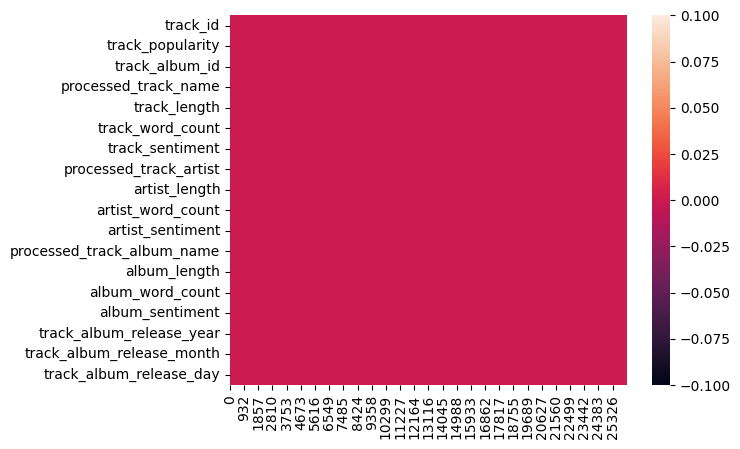

In [ ]:
sns.heatmap(df_track.isna().T);

* **After splitting the datetime feature, some NAN values appear, so we drop them.**

In [ ]:
df_track.dropna(inplace=True)

In [ ]:
df_track["track_id"].nunique()

21790

In [ ]:
df_track[df_track["track_id"].duplicated(keep=False)]

,track_id,track_popularity,track_album_id,processed_track_name,track_length,track_word_count,track_sentiment,processed_track_artist,artist_length,artist_word_count,artist_sentiment,processed_track_album_name,album_length,album_word_count,album_sentiment,track_album_release_year,track_album_release_month,track_album_release_day
0,1Y373MqadDRtclJNdnUXVc,68,6r7LZXAVueS5DqdrvXJJK7,paranoid 2016 remaster,22,3,0.0,black sabbath,13,2,-0.166667,paranoid 2014 remaster,22,3,0.000000,1970,9,18
18,1KdGSnUj7Zr1XdTbyuSr7T,53,5dWDdM416kzNTDKZEEvRUz,freaking,8,1,0.0,wreck,5,1,0.000000,freaking,8,1,0.000000,2019,6,21
19,297rZsBEjFw9d0Gl3iBLnd,45,31u58iuxrUOJeKJj4SKqOl,goodie bag,10,2,0.0,still woozy,11,2,0.000000,goodie bag,10,2,0.000000,2017,11,5
32,555ix1gW9A1QtXoVfCPbfB,69,1SvuC2OLkAJnuNhZNDohIR,solita,6,1,0.0,kali uchis,10,2,0.000000,solita,6,1,0.000000,2019,12,4
35,2YpeDb67231RjR0MgVLzsG,90,4IRiXE5NROxknUSAUSjMoO,old town road remix,19,4,0.1,lil na x,8,3,0.000000,7 ep,4,2,0.000000,2019,6,21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26245,4w5Grfxx5Rpup6mo5v6bW0,67,6NQRmMazNOKi0IiIXlNzGh,beat heart,10,2,0.0,lost frequency,14,2,0.000000,alive feeling fine,18,3,0.258333,2019,10,4
26247,4JxXwBcVpVGDAnY4tKcAFH,15,76ktGiqmday72vNtX2RcAq,another day,11,2,0.0,l e,3,2,0.000000,rise,4,1,0.000000,2019,5,19
26248,4kAtRwNRLMKuoCbxMSxUGI,69,0mfiGkVJST0ysEVznu2aZP,noche de sexo,13,3,0.0,wisin yandel,12,2,0.000000,pal mundo,9,2,0.000000,2005,1,1
26249,1Ahp4PZ1vzdbzBCedUrsqI,62,3AlSuZnX4ZCab8eoWnnfbm,one,3,1,0.0,jorja smith,11,2,0.000000,lost found,10,2,0.000000,2018,6,8


* **We discover here, some track_id are uplicated, so we delete them.**

In [ ]:
df_track[df_track['track_id'] == "1Y373MqadDRtclJNdnUXVc"]

,track_id,track_popularity,track_album_id,processed_track_name,track_length,track_word_count,track_sentiment,processed_track_artist,artist_length,artist_word_count,artist_sentiment,processed_track_album_name,album_length,album_word_count,album_sentiment,track_album_release_year,track_album_release_month,track_album_release_day
0,1Y373MqadDRtclJNdnUXVc,68,6r7LZXAVueS5DqdrvXJJK7,paranoid 2016 remaster,22,3,0.0,black sabbath,13,2,-0.166667,paranoid 2014 remaster,22,3,0.0,1970,9,18
4903,1Y373MqadDRtclJNdnUXVc,68,6r7LZXAVueS5DqdrvXJJK7,paranoid 2016 remaster,22,3,0.0,black sabbath,13,2,-0.166667,paranoid 2014 remaster,22,3,0.0,1970,9,18
18480,1Y373MqadDRtclJNdnUXVc,68,6r7LZXAVueS5DqdrvXJJK7,paranoid 2016 remaster,22,3,0.0,black sabbath,13,2,-0.166667,paranoid 2014 remaster,22,3,0.0,1970,9,18


In [ ]:
df_track[df_track['track_id'] == "1abFkY2jm6KDFMZ7RD9YJh"]

,track_id,track_popularity,track_album_id,processed_track_name,track_length,track_word_count,track_sentiment,processed_track_artist,artist_length,artist_word_count,artist_sentiment,processed_track_album_name,album_length,album_word_count,album_sentiment,track_album_release_year,track_album_release_month,track_album_release_day
5580,1abFkY2jm6KDFMZ7RD9YJh,74,68WyGdXBIZQZLezPVSDrxC,painkiller,10,1,0.0,ruel,4,1,0.0,painkiller,10,1,0.0,2019,4,30
13508,1abFkY2jm6KDFMZ7RD9YJh,74,68WyGdXBIZQZLezPVSDrxC,painkiller,10,1,0.0,ruel,4,1,0.0,painkiller,10,1,0.0,2019,4,30
26253,1abFkY2jm6KDFMZ7RD9YJh,74,68WyGdXBIZQZLezPVSDrxC,painkiller,10,1,0.0,ruel,4,1,0.0,painkiller,10,1,0.0,2019,4,30


In [ ]:
df.drop_duplicates(subset=["track_id"], inplace=True)

* **Track Name**

Build an application to delete the duplicate track name, keep in consideration the same date of release and the same artist. Also keep the average of the track popularity.

In [ ]:
"""
df_track["track_name"].nunique()
df_track[df_track["track_name"].duplicated(keep=False)]
df_track[df_track['track_name'] == "Sorry"]
df_track[df_track['track_name'] == "Noche De Sexo"]
df_track[df_track.duplicated(subset=["track_name", "track_artist", "track_album_release_year", "track_album_release_month", "track_album_release_day"], keep=False)]
"""
print()

* **Album ID**

In [ ]:
# df_track["track_album_id"].nunique()

* **Artist**

In [ ]:
# df_track["track_artist"].nunique()

In [ ]:
df_track.to_csv('processed_df_track.csv', index=False)

# Playlist Features: 90% done

* track_id:
* playlist_name: **done**
* playlist_id: **done**
* playlist_genre: **done**
* playlist_subgenre: **done**

In [ ]:
df_playlist

,track_id,playlist_name,playlist_id,playlist_genre,playlist_subgenre
0,1Y373MqadDRtclJNdnUXVc,Classic Rock Workout,37i9dQZF1DWYNSm3Z3MxiM,rock,classic rock
1,40WzXFabdkT1KCgRYwoz8X,90s Dance Hits,50cXvxgMGrvoUeLhkzCyIO,pop,dance pop
2,3irumzUB7UlJqoVZCqR3kI,Neo Soul / Modern Jazz / Smooth Hiphop,07SNJ4MwYba9wwmzrbjmYi,r&b,neo soul
3,1c6WvcGhLnOCjxFNOvQ2k6,Vocal House,5PCAWKfUWAUj8VeY8G7xRQ,edm,progressive electro house
4,5c5nIaR4AlqYK1cZhCBOKH,Trapperz,37i9dQZF1DWUmxBdWX3Pp4,rap,trap
...,...,...,...,...,...
26261,6MY8JB1THlKqdyqe5YSAng,Tropical House 🌴,06zrBJ5cts5aemZmqe80J7,latin,tropical
26262,4r2WD5ZnLazPfsWqDWfK4F,A1 Hip-Hop,37i9dQZF1DX0sDai2F5jCQ,rap,hip hop
26263,4g9TfQAiEN6lDNRJJsiU9T,This Is Guns N' Roses,37i9dQZF1DX74DnfGTwugU,rock,album rock
26264,0m8YMp4kDDFVATJCVIdhOv,Christian Dance Party,37i9dQZF1DWUUPO0Sbx2CM,pop,dance pop


In [ ]:
track_columns_before_processing = df_playlist.columns.tolist()
track_columns_before_processing

['track_id',
 'playlist_name',
 'playlist_id',
 'playlist_genre',
 'playlist_subgenre']

In [ ]:
ttrack_columns_after_processing = df_playlist.columns.tolist()
ttrack_columns_after_processing

['track_id',
 'playlist_name',
 'playlist_id',
 'playlist_genre',
 'playlist_subgenre']

In [ ]:
new_track_columns = ['track_id', 'playlist_genre', 'playlist_subgenre_first_word', 'playlist_subgenre_last_word', 'processed_playlist_name', 'playlist_length', 'playlist_word_count', 'playlist_sentiment', 'genre_category']

* **How many playlist we have**

Why this different

In [ ]:
df_playlist["playlist_id"].nunique()

470

In [ ]:
df_playlist["playlist_name"].nunique()

448

In average we have 55 track in each playlist

In [ ]:
26266 / 470

55.88510638297873

In [ ]:
df_playlist.playlist_name.value_counts()

,count
playlist_name,
Indie Poptimism,237
Permanent Wave,200
2020 Hits & 2019 Hits – Top Global Tracks 🔥🔥🔥,194
Hard Rock Workout,173
Ultimate Indie Presents... Best Indie Tracks of the 2010s,159
...,...
RADIO POP CHARTS,6
URBAN NATION,6
TOP 50 GLOBAL 2020 UPDATED WEEKLY 🌍🎶 WORLDWIDE,4


In [ ]:
playlist_pipeline = Pipeline([
    ('PlaylistProcessing', TextProcessing(column_name='playlist_name', feature='playlist'))
])

In [ ]:
df_playlist = playlist_pipeline.fit_transform(df_playlist)

In [ ]:
"""
# 1. Text Normalization
df_playlist['processed_playlist_name'] = df.playlist_name.str.lower()

# Normalize accents/diacritics (e.g., convert é to e)
def normalize_text(text):
  return unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8')

df_playlist['processed_playlist_name'] = df_playlist['processed_playlist_name'].apply(normalize_text)

# 2. Remove Special Characters and Emojis

def clean_text(text):
  # Remove URLs
  text = re.sub(r'http\S+', '', text)
  # Replace emojis with their textual description
  text = emoji.replace_emoji(text, replace='')
  # Remove special characters (keep letters, numbers, and spaces)
  text = re.sub(r'[^a-z0-9\s]', '', text)
  # Collabse multiple space
  text = re.sub(r'\s+', ' ', text).strip()
  return text

df_playlist['processed_playlist_name'] = df_playlist.processed_playlist_name.apply(clean_text)


# 3. Tokenization and Stopword Removal

# Split text into tokens and remove noise.


# Download NLTK resources (run once)


stop_words = set(stopwords.words('english'))

def tokenize_and_remove_stopwords(text):
    tokens = word_tokenize(text)
    return ' '.join([token for token in tokens if token not in stop_words])

df_playlist['processed_playlist_name'] = df_playlist.processed_playlist_name.apply(tokenize_and_remove_stopwords)

# 4. Lemmatization & Stemming

# Recude words to their base form

lemmatizer = WordNetLemmatizer()
nltk.download('wordnet') # Run once

def lemmatize_text(text):
  tokens = word_tokenize(text)
  return ' '.join([lemmatizer.lemmatize(token) for token in tokens])

df_playlist['processed_playlist_name'] = df_playlist.processed_playlist_name.apply(lemmatize_text)

# 6. Feature Engineering

# Create additional features for analysis.

# Length of playlist name
df_playlist['playlist_length'] = df_playlist.processed_playlist_name.apply(len)

# Count of words in playlist name
df_playlist['playlist_word_count'] = df_playlist.processed_playlist_name.apply(lambda x: len(x.split()))

# Sentiment analysis (example using TextBlob)
df_playlist['playlist_sentiment'] = df_playlist.processed_playlist_name.apply(lambda x: TextBlob(x).sentiment.polarity)
"""
print()

In [ ]:
# 1. Vectorization for ML
tfidf = TfidfVectorizer(ngram_range=(1, 2), max_features=1000)
tfidf_matrix = tfidf.fit_transform(df_playlist['processed_playlist_name'])

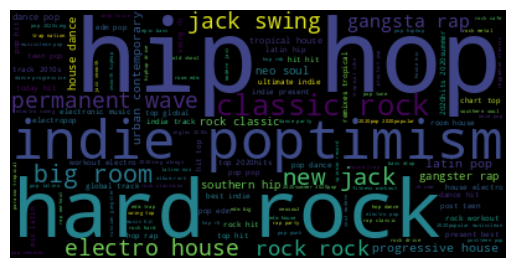

In [ ]:
# 2. Visualization

# Analyze word frequency


wordcloud = WordCloud().generate(' '.join(df_playlist.processed_playlist_name))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [ ]:
# 3. Validation
df_playlist['processed_playlist_name'].sample(10)

,processed_playlist_name
10696,popular 2020 top 50
11784,orgulho tropical
2423,todo exitos
287,dance pop
10647,neo soul modern jazz smooth hiphop
1771,eletric pop dance
10649,90 gangsta rap top hiphop classic
14978,pop hit 20002019
23606,fresh edm progressive house electro house trap...
578,modern indie rock alternative rock garage rock...


In [ ]:
# Convert to dense array for viewing (only do this for small matrices)
dense_matrix = tfidf_matrix.toarray()
print(dense_matrix)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


* **How many genre we have**

In [ ]:
df_playlist['playlist_genre'].unique()

array(['rock', 'pop', 'r&b', 'edm', 'rap', 'latin'], dtype=object)

edm **<=>** Electronic Dance Music

r&b **<=>** Rhythm and Blues

In [ ]:
df_playlist['playlist_genre'].value_counts()

,count
playlist_genre,
edm,4825
rap,4578
pop,4426
r&b,4400
latin,4122
rock,3915


* **playlist_subgenre**

In [ ]:
df_playlist['playlist_subgenre'].value_counts()

,count
playlist_subgenre,
progressive electro house,1473
indie poptimism,1342
latin hip hop,1341
southern hip hop,1328
neo soul,1314
electro house,1202
pop edm,1192
hard rock,1172
gangster rap,1162


In [ ]:
def categorize_subgenre(subgenre):
    """Categorizes a music subgenre into broader genre families based on keywords."""

    edm_keywords = ["edm", "electro", "house", "dance", "big room", "tropical"]
    hip_hop_keywords = ["hip hop", "rap", "trap", "urban"]
    rock_keywords = ["rock", "wave", "album"]
    pop_keywords = ["pop", "poptimism", "post-teen"]
    rnb_keywords = ["soul", "swing"]
    latin_keywords = ["latin", "reggaeton"]

    # Convert to lowercase for case-insensitive matching
    subgenre = subgenre.lower()

    # Check which category the subgenre belongs to
    if any(keyword in subgenre for keyword in edm_keywords):
        return "EDM Dance"
    elif any(keyword in subgenre for keyword in hip_hop_keywords):
        return "Hip-Hop Rap"
    elif any(keyword in subgenre for keyword in rock_keywords):
        return "Rock Alternative"
    elif any(keyword in subgenre for keyword in pop_keywords):
        return "Pop Mainstream"
    elif any(keyword in subgenre for keyword in rnb_keywords):
        return "R&B Soul"
    elif any(keyword in subgenre for keyword in latin_keywords):
        return "Latin Reggaeton"
    else:
        return "Other"

In [ ]:
df_playlist["genre_category"] = df_playlist["playlist_subgenre"].apply(categorize_subgenre)

In [ ]:
df_playlist['genre_category'].value_counts()

,count
genre_category,
EDM Dance,8034
Hip-Hop Rap,7067
Pop Mainstream,4264
Rock Alternative,3915
R&B Soul,2224
Latin Reggaeton,762


In [ ]:
df_playlist#[new_track_columns]

,track_id,playlist_id,playlist_genre,playlist_subgenre,processed_playlist_name,playlist_length,playlist_word_count,playlist_sentiment,genre_category
0,1Y373MqadDRtclJNdnUXVc,37i9dQZF1DWYNSm3Z3MxiM,rock,classic rock,classic rock workout,20,3,0.166667,Rock Alternative
1,40WzXFabdkT1KCgRYwoz8X,50cXvxgMGrvoUeLhkzCyIO,pop,dance pop,90 dance hit,12,3,0.000000,EDM Dance
2,3irumzUB7UlJqoVZCqR3kI,07SNJ4MwYba9wwmzrbjmYi,r&b,neo soul,neo soul modern jazz smooth hiphop,34,6,0.300000,R&B Soul
3,1c6WvcGhLnOCjxFNOvQ2k6,5PCAWKfUWAUj8VeY8G7xRQ,edm,progressive electro house,vocal house,11,2,0.000000,EDM Dance
4,5c5nIaR4AlqYK1cZhCBOKH,37i9dQZF1DWUmxBdWX3Pp4,rap,trap,trapperz,8,1,0.000000,Hip-Hop Rap
...,...,...,...,...,...,...,...,...,...
26261,6MY8JB1THlKqdyqe5YSAng,06zrBJ5cts5aemZmqe80J7,latin,tropical,tropical house,14,2,0.000000,EDM Dance
26262,4r2WD5ZnLazPfsWqDWfK4F,37i9dQZF1DX0sDai2F5jCQ,rap,hip hop,a1 hiphop,9,2,0.000000,Hip-Hop Rap
26263,4g9TfQAiEN6lDNRJJsiU9T,37i9dQZF1DX74DnfGTwugU,rock,album rock,gun n rose,10,3,0.600000,Rock Alternative
26264,0m8YMp4kDDFVATJCVIdhOv,37i9dQZF1DWUUPO0Sbx2CM,pop,dance pop,christian dance party,21,3,0.000000,EDM Dance


In [ ]:
class SubgenreExtractor(BaseEstimator, TransformerMixin):
  def fit(self, X, y=None):
    return self
  def transform(self, X):
    X = X.copy()
    X['playlist_subgenre_first_word'] = X.playlist_subgenre.str.split(' ').str[0]
    X['playlist_subgenre_last_word'] = X.playlist_subgenre.str.split(' ').str[-1]
    return X

In [ ]:
df_playlist['playlist_subgenre_first_word'] = df_playlist.playlist_subgenre.str.split(' ').str[0]
df_playlist['playlist_subgenre_last_word'] = df_playlist.playlist_subgenre.str.split(' ').str[-1]

In [ ]:
#df_playlist.playlist_subgenre.str.split(' ').str[0].value_counts()

In [ ]:
#df_playlist.playlist_subgenre.value_counts()

In [ ]:
#df_playlist.playlist_genre.value_counts()

In [ ]:
df_playlist.to_csv('processed_df_playlist.csv', index=False)

# Audio Features: Done 100%

* track_id
* danceability
* energy
* key
* loudness
* mode
* speechiness
* acousticness
* instrumentalness
* liveness
* valence
* tempo: done to tempo_category
* duration_ms: done to duration_min
* track_popularity

In [ ]:
#https://chatgpt.com/share/67d84db2-4384-8010-83bd-3ddd7b1e79fc

In [ ]:
df_audio

,track_id,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,track_popularity
0,1Y373MqadDRtclJNdnUXVc,0.415,0.658,4,-12.051,0,0.0696,0.000045,0.000735,0.1760,0.450,163.015,168406,68
1,40WzXFabdkT1KCgRYwoz8X,0.655,0.884,6,-6.515,0,0.0602,0.010200,0.000000,0.2590,0.772,140.008,219240,1
2,3irumzUB7UlJqoVZCqR3kI,0.847,0.696,5,-6.113,0,0.0642,0.052000,0.004020,0.0795,0.763,140.678,183253,33
3,1c6WvcGhLnOCjxFNOvQ2k6,0.596,0.910,9,-5.937,0,0.0385,0.000629,0.001370,0.1780,0.484,127.963,182461,0
4,5c5nIaR4AlqYK1cZhCBOKH,0.877,0.665,1,-6.116,1,0.0538,0.406000,0.000035,0.2320,0.143,122.004,199078,45
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26261,6MY8JB1THlKqdyqe5YSAng,0.714,0.818,0,-2.828,1,0.0312,0.315000,0.000000,0.4410,0.521,99.946,170400,30
26262,4r2WD5ZnLazPfsWqDWfK4F,0.815,0.624,6,-6.096,0,0.4490,0.389000,0.000000,0.0724,0.561,139.736,180152,57
26263,4g9TfQAiEN6lDNRJJsiU9T,0.402,0.502,2,-10.009,0,0.0315,0.070200,0.000064,0.1150,0.209,147.519,374187,49
26264,0m8YMp4kDDFVATJCVIdhOv,0.589,0.592,7,-7.887,0,0.0334,0.005980,0.000000,0.0614,0.348,141.131,213723,31


In [ ]:
df_audio.columns.tolist()

['track_id',
 'danceability',
 'energy',
 'key',
 'loudness',
 'mode',
 'speechiness',
 'acousticness',
 'instrumentalness',
 'liveness',
 'valence',
 'tempo',
 'duration_ms',
 'track_popularity']

In [ ]:
max(df_audio.instrumentalness)

0.994

In [ ]:
max(df_audio.tempo), min(df_audio.tempo)

(239.44, 35.477)

In [ ]:
class MsToMinutes(BaseEstimator, TransformerMixin):
  def fit(self, X, y=None):
    return self
  def transform(self, X):
    X['duration_min'] = (X['duration_ms'] / 60000).round(2)
    return X.drop(['duration_ms'], axis=1)

In [ ]:
max(df_audio.tempo), min(df_audio.tempo)

(239.44, 35.477)

In [ ]:
from sklearn.preprocessing import StandardScaler
class TempoScaler(BaseEstimator, TransformerMixin):
  def fit(self, X, y=None):
    return self
  def transform(self, X):
    sclaer = StandardScaler()
    X['tempo_scaled'] = sclaer.fit_transform(X[['tempo']])
    return X.drop(['tempo'], axis=1)

In [ ]:
audio_features_pipeline = Pipeline([
    ('MsToMinutes', MsToMinutes()),
    ('TempoScaler', TempoScaler())
])

In [ ]:
df_audio = audio_features_pipeline.fit_transform(df_audio)

In [ ]:
df_audio

,track_id,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,track_popularity,duration_min,tempo_scaled
0,1Y373MqadDRtclJNdnUXVc,0.415,0.658,4,-12.051,0,0.0696,0.000045,0.000735,0.1760,0.450,68,2.81,1.564969
1,40WzXFabdkT1KCgRYwoz8X,0.655,0.884,6,-6.515,0,0.0602,0.010200,0.000000,0.2590,0.772,1,3.65,0.710099
2,3irumzUB7UlJqoVZCqR3kI,0.847,0.696,5,-6.113,0,0.0642,0.052000,0.004020,0.0795,0.763,33,3.05,0.734994
3,1c6WvcGhLnOCjxFNOvQ2k6,0.596,0.910,9,-5.937,0,0.0385,0.000629,0.001370,0.1780,0.484,0,3.04,0.262544
4,5c5nIaR4AlqYK1cZhCBOKH,0.877,0.665,1,-6.116,1,0.0538,0.406000,0.000035,0.2320,0.143,45,3.32,0.041126
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26261,6MY8JB1THlKqdyqe5YSAng,0.714,0.818,0,-2.828,1,0.0312,0.315000,0.000000,0.4410,0.521,30,2.84,-0.778482
26262,4r2WD5ZnLazPfsWqDWfK4F,0.815,0.624,6,-6.096,0,0.4490,0.389000,0.000000,0.0724,0.561,57,3.00,0.699993
26263,4g9TfQAiEN6lDNRJJsiU9T,0.402,0.502,2,-10.009,0,0.0315,0.070200,0.000064,0.1150,0.209,49,6.24,0.989185
26264,0m8YMp4kDDFVATJCVIdhOv,0.589,0.592,7,-7.887,0,0.0334,0.005980,0.000000,0.0614,0.348,31,3.56,0.751827


In [ ]:
df_audio[df_audio.columns.drop("track_id").tolist()].corr().style.background_gradient(cmap='coolwarm')

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,track_popularity,duration_min,tempo_scaled
danceability,1.000000,-0.084648,0.010708,0.027127,-0.057438,0.182039,-0.024890,-0.009663,-0.127328,0.331966,0.064620,-0.100075,-0.190654
energy,-0.084648,1.000000,0.014571,0.674697,-0.006768,-0.029755,-0.540099,0.034275,0.159069,0.154444,-0.111265,0.010619,0.148846
key,0.010708,0.014571,1.000000,0.004815,-0.176660,0.020835,-0.003724,0.001883,0.004563,0.019897,-0.004973,0.014339,-0.009628
loudness,0.027127,0.674697,0.004815,1.000000,-0.022080,0.011936,-0.361671,-0.149564,0.075271,0.055058,0.056204,-0.117829,0.088809
mode,-0.057438,-0.006768,-0.176660,-0.022080,1.000000,-0.066319,0.004918,-0.005099,-0.007337,0.000313,0.015041,0.016658,0.011549
speechiness,0.182039,-0.029755,0.020835,0.011936,-0.066319,1.000000,0.028856,-0.102438,0.053797,0.067254,0.006131,-0.095124,0.041587
acousticness,-0.024890,-0.540099,-0.003724,-0.361671,0.004918,0.028856,1.000000,-0.008810,-0.076053,-0.018537,0.087813,-0.077807,-0.113377
instrumentalness,-0.009663,0.034275,0.001883,-0.149564,-0.005099,-0.102438,-0.008810,1.000000,-0.002897,-0.168416,-0.150154,0.069977,0.029283
liveness,-0.127328,0.159069,0.004563,0.075271,-0.007337,0.053797,-0.076053,-0.002897,1.000000,-0.018343,-0.053854,0.005936,0.022925
valence,0.331966,0.154444,0.019897,0.055058,0.000313,0.067254,-0.018537,-0.168416,-0.018343,1.000000,0.030355,-0.036426,-0.028229


In [ ]:
df_audio.to_csv('processed_df_audio.csv', index=False)